# Aufgabe 06 - CNN fashion mnist under attack
03.12.2021, Thomas Iten

**Part I: Create and train CNN**
1. Downlaod and transform data
2. Create data loaders
3. Define Network, output, loss and optimizer
4. Train and test model
5. Save trained model


**Part II: Prepare and run FGSM Attack**
<ol start="6">
    <li>Load trained model and set to evaluation mode</li>
    <li>Prepare FGSM attack</li>
    <li>Define test function</li>
    <li>Run attack</li>
    <li>Visualize results</li>
</ol>

**Part III: Serve model with BentoML**
<ol start="11">
    <li>Define BentoML PyTorchFashionClassifier</li>
    <li>Load trained model and set to evaluation mode</li>
    <li>Save BentoML artifacts</li>
    <li>Run BentoML service</li>
</ol>


# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T

from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
from torch.utils.data import DataLoader

from __future__ import print_function
%matplotlib inline

# NOTE: This is a hack to get around "User-agent" limitations when downloading MNIST datasets
# see, https://github.com/pytorch/vision/issues/3497 for more information
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

# Part I: Create and train CNN

## 1. Downlaod and transform data

In [2]:
# Performs worse than the simple ToTensor()
train_transform = T.Compose([ T.ToTensor(),
                              T.Normalize((0.5,), (0.5,))])

# Download training data from open datasets.  
training_data = datasets.FashionMNIST(        # 60'000 
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.      # 10'000
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



## 2. Create data loaders

In [3]:
batch_size = 32

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)   #1, 1, 28, 28
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([1, 1, 28, 28])
Shape of y:  torch.Size([1]) torch.int64


## 3. Define Network, output, loss and optimizer

### Define network

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3 )    # 1 entspricht Dimension graustufe
        self.norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.norm2 = nn.BatchNorm2d(64)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1600, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        debug = False
        x = self.conv1(x)
        if debug:
          print(x.shape)
        x = self.norm1(x)
        x = F.relu(F.max_pool2d(x, 2))                  # CNN uses always RELU!
        if debug:
          print(x.shape)
        x = self.conv2_drop(self.conv2(x))
        if debug:
          print(x.shape)
        x = self.norm2(x)
        x = F.relu(F.max_pool2d(x, 2))
        if debug:        
          print(x.shape)
        x = x.view(-1, 1600)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Define what device we are using
use_cuda=False
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
print("Using device:", device)

# Initialize the network
model = Net().to(device)
print(model)
y_hat = model(X)


Using device: cpu
Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1600, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


### SH is the image shape with
- W is the input width - in our case 28
- H is the input hight - in our case 28
- K is the Kernel size - in our case 5, 5
- P is the padding - in our case 0, 0
- S is the stride - 1, 1
- D - dilation 1, 1

In [5]:
def output(SH, K, P, S, D):
  return ((SH[0] + 2*P[0] - D[0]*(K[0]-1) - 1)/S[0])+1, ((SH[1] + 2*P[1] - D[1]*(K[1]-1) - 1)/S[1])+1

output((28, 28), (5,5), (0,0), (1, 1), (1, 1))


(24.0, 24.0)

### Loss and optimizer

In [6]:
loss_fn = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)


## 4. Train and test model

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [8]:
epochs = 30
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.284795  [    0/60000]
loss: 2.195952  [ 3200/60000]
loss: 2.134166  [ 6400/60000]
loss: 1.997464  [ 9600/60000]
loss: 1.801897  [12800/60000]
loss: 1.859882  [16000/60000]
loss: 1.313843  [19200/60000]
loss: 1.482859  [22400/60000]
loss: 1.379794  [25600/60000]
loss: 1.532684  [28800/60000]
loss: 1.250551  [32000/60000]
loss: 1.214574  [35200/60000]
loss: 1.419725  [38400/60000]
loss: 1.408093  [41600/60000]
loss: 1.067169  [44800/60000]
loss: 1.275633  [48000/60000]
loss: 1.001281  [51200/60000]
loss: 1.137400  [54400/60000]
loss: 1.048506  [57600/60000]
Test Error: 
 Accuracy: 75.2%, Avg loss: 0.839107 

Epoch 2
-------------------------------
loss: 1.059969  [    0/60000]
loss: 1.074746  [ 3200/60000]
loss: 1.087147  [ 6400/60000]
loss: 1.292009  [ 9600/60000]
loss: 1.048605  [12800/60000]
loss: 0.976831  [16000/60000]
loss: 0.759759  [19200/60000]
loss: 0.756856  [22400/60000]
loss: 0.907192  [25600/60000]
loss: 1.299536  [28800/60000

## 5. Save trained model

In [9]:
pretrained_model = "06_cnn_fashion_mnist_model.pth"
torch.save(model.state_dict(), pretrained_model)

# Part II: Prepare and run FGSM Attack

## 6. Load trained model and set to evaluation mode

In [10]:
# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1600, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

## 7. Prepare FGSM attack

Now, we can define the function that creates the adversarial examples by perturbing the original inputs.

The ``fgsm_attack`` function takes three inputs:,
- **image** is the original clean image ($x$),
- **epsilon** is the pixel-wise perturbation amount ($\epsilon$)
- **data_grad** is gradient of the loss w.r.t the input image
  ($\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y)$).

The function then creates perturbed image as:
> perturbed_image = image + epsilon * sign(data_grad)<br />
> perturbed_image = x + epsilon * sign(nabla_{x} J(mathbf{theta}, \mathbf{x}, y))

Finally, in order to maintain the original range of the data, the perturbed image is clipped to range $[0,1]$.

In [11]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

## 8. Define test function

Finally, the central result of this tutorial comes from the ``test`` function.
- Each call to this test function performs a full test step on the testdata set and reports a final accuracy.

However, notice that this function also takes an *epsilon* input.
- This is because the ``test`` function reports the accuracy of a model that is under attack from an adversary with strength $\epsilon$.
- More specifically, for each sample in the test set, the function computes the gradient of the loss w.r.t the input data ($data\_grad$),
  creates a perturbed image with ``fgsm_attack`` ($perturbed\_data$), then checks to see if the perturbed example is adversarial.

In addition to testing the accuracy of the model, the function also saves and returns some successful adversarial examples to be visualized later.


In [12]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

## 9. Run attack
The last part of the implementation is to actually run the attack. Here, we run a full test step for each epsilon value in the *epsilons* input.
- For each epsilon we also save the final accuracy and some successful adversarial examples to be plotted in the coming sections.
- Notice how the printed accuracies decrease as the epsilon value increases. Also, note the $\epsilon=0$ case represents the original test accuracy, with no attack.



**epsilons**
- List of epsilon values to use for the run.
- It is **important to keep 0** in the list because it represents the model performance on the original test set.
- Also, intuitively we would expect the larger the epsilon, the more noticeable the perturbations but the
  more effective the attack in terms of degrading model accuracy.
- Since the data range here is $[0,1]$, no epsilon value should exceed 1.

In [13]:
epsilons = [0, .05, .1, .15, .2, .25, .3, .35, .4]

accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_dataloader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 8753 / 10000 = 0.8753
Epsilon: 0.05	Test Accuracy = 5981 / 10000 = 0.5981
Epsilon: 0.1	Test Accuracy = 4438 / 10000 = 0.4438
Epsilon: 0.15	Test Accuracy = 3129 / 10000 = 0.3129
Epsilon: 0.2	Test Accuracy = 2071 / 10000 = 0.2071
Epsilon: 0.25	Test Accuracy = 1325 / 10000 = 0.1325
Epsilon: 0.3	Test Accuracy = 773 / 10000 = 0.0773
Epsilon: 0.35	Test Accuracy = 502 / 10000 = 0.0502
Epsilon: 0.4	Test Accuracy = 427 / 10000 = 0.0427


## 10. Visualize results

### Accuracy vs Epsilon

The first result is the accuracy versus epsilon plot.
- As alluded to earlier, as epsilon increases we expect the test accuracy to decrease.
- This is because larger epsilons mean we take a larger step in the direction that will maximize the loss.
- Notice the trend in the curve is not linear even though the epsilon values are linearly spaced.

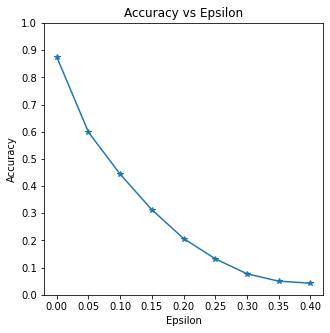

In [14]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .45, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

### Sample Adversarial Examples

Remember the idea of no free lunch? In this case, as epsilon increases the test accuracy decreases **BUT**
the perturbations become more easily perceptible.
- In reality, there is a **tradeoff between accuracy degredation and perceptibility** that an attacker must consider.
- Here, we show some examples of successful adversarial examples at each epsilon value.
- Each row of the plot shows a different epsilon value.
- The first row is the $\epsilon=0$ examples which represent the **original “clean” images** with no perturbation.
- The title of each image shows the “original classification -> adversarial classification.”

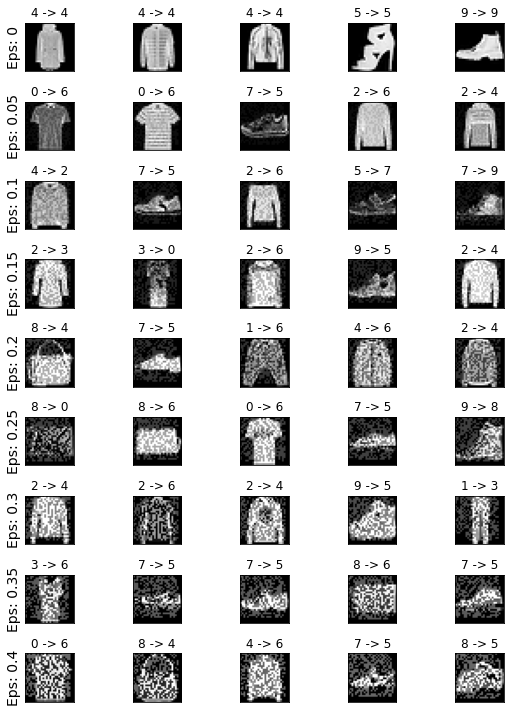

In [15]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

# Part III: Serve model with BentoML

Reference: https://www.bentoml.ai/

## 11. Define BentoML PyTorchFashionClassifier

In [16]:
%%writefile bentoml_pytorch_fashion_mnist_classifier.py

from typing import BinaryIO, List
import bentoml
from PIL import Image
import io
import torch
from torchvision import transforms
from bentoml.frameworks.pytorch import PytorchModelArtifact
from bentoml.adapters import FileInput, JsonOutput, ImageInput

FASHION_MNIST_CLASSES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                         'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

@bentoml.env(pip_packages=['torch', 'pillow', 'numpy', 'torchvision', 'scikit-learn'])
@bentoml.artifacts([PytorchModelArtifact('model')])
class PyTorchFashionClassifier(bentoml.BentoService):

    @bentoml.utils.cached_property  # reuse transformer
    def transform(self):
        return transforms.Compose([transforms.CenterCrop((29, 29)), transforms.ToTensor()])

    @bentoml.api(input=FileInput(), output=JsonOutput(), batch=True)
    def predict(self, file_streams: List[BinaryIO]) -> List[str]:
        img_tensors = []
        for fs in file_streams:
            img = Image.open(fs).convert(mode="L").resize((28, 28))
            img_tensors.append(self.transform(img))
        outputs = self.artifacts.model(torch.stack(img_tensors))
        _, output_classes = outputs.max(dim=1)

        return [FASHION_MNIST_CLASSES[output_class] for output_class in output_classes]

Overwriting bentoml_pytorch_fashion_mnist_classifier.py


## 12. Load trained model and set to evaluation mode

In [17]:
model = Net().to(device)
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1600, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

## 13. Save BentoML artifacts

In [18]:
# import the custom BentoService defined above
from bentoml_pytorch_fashion_mnist_classifier import PyTorchFashionClassifier

# `pack` it with required artifacts
bento_svc = PyTorchFashionClassifier()
bento_svc.pack('model', model)

# save your BentoSerivce
saved_path = bento_svc.save()
saved_path

[2021-12-03 22:48:12,629] WARNING - Python 3.9.5 found in current environment is not officially supported by BentoML. The docker base image used is'bentoml/model-server:0.13.1' which will use conda to install Python 3.9.5 in the build process. Supported Python versions are: f3.6, 3.7, 3.8
[2021-12-03 22:48:12,630] WARNING - BentoML by default does not include spacy and torchvision package when using PytorchModelArtifact. To make sure BentoML bundle those packages if they are required for your model, either import those packages in BentoService definition file or manually add them via `@env(pip_packages=['torchvision'])` when defining a BentoService
[2021-12-03 22:48:14,231] INFO - BentoService bundle 'PyTorchFashionClassifier:20211203224813_1CDEF1' saved to: C:\Users\ti\bentoml\repository\PyTorchFashionClassifier\20211203224813_1CDEF1


'C:\\Users\\ti\\bentoml\\repository\\PyTorchFashionClassifier\\20211203224813_1CDEF1'

## 14. Run BentoML service

1. Start Server with the following command.
2. Open URL http://127.0.0.1:5000/

In [19]:
!bentoml serve PyTorchFashionClassifier:latest --run-with-ngrok --debug


^C


---
The end.
